In [1]:
!pip install ucimlrepo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap

from sklearn.ensemble import IsolationForest
from ucimlrepo import fetch_ucirepo

# set figure background to white
plt.rcParams.update({'figure.facecolor':'white'})

## Data Cleaning and Feature Engineering

In [3]:
# fetch the dataset from UCI repo
power_consumption = fetch_ucirepo(id=235)

print(power_consumption.variables)

/usr/local/lib/python3.11/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


                    name     role         type demographic description units  \
0                   Date  Feature         Date        None        None  None   
1                   Time  Feature  Categorical        None        None  None   
2    Global_active_power  Feature   Continuous        None        None  None   
3  Global_reactive_power  Feature   Continuous        None        None  None   
4                Voltage  Feature   Continuous        None        None  None   
5       Global_intensity  Feature   Continuous        None        None  None   
6         Sub_metering_1  Feature   Continuous        None        None  None   
7         Sub_metering_2  Feature   Continuous        None        None  None   
8         Sub_metering_3  Feature   Continuous        None        None  None   

  missing_values  
0             no  
1             no  
2             no  
3             no  
4             no  
5             no  
6             no  
7             no  
8             no  


In [4]:
# get all the features
data = power_consumption.data.features
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

# list of all the features to check
feature_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                   'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# converts feature columns to numeric and replae any errors with NaN
data[feature_columns] = data[feature_columns].apply(pd.to_numeric, errors='coerce')

# drop rows where all feature columns are missing (NaN)
data_cleaned = data.dropna(subset=feature_columns, how='all')

# drop rows where ALL feature columns are NaN
data_cleaned.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
# group by 'Date' and calculate mean and standard deviation (ignore NaN values)
data_aggregated = data_cleaned.groupby('Date')[feature_columns].agg(['mean', 'std'])

# rename columns to the desired format (MEAN_ColumnName, STD_ColumnName)
data_aggregated.columns = [f'{agg_type.upper()}_{col}' for col, agg_type in data_aggregated.columns]

# reset the index
data_aggregated.reset_index(inplace=True)

# display the results
print(data_aggregated.shape)
data_aggregated.head()

(1433, 15)


,Date,MEAN_Global_active_power,STD_Global_active_power,MEAN_Global_reactive_power,STD_Global_reactive_power,MEAN_Voltage,STD_Voltage,MEAN_Global_intensity,STD_Global_intensity,MEAN_Sub_metering_1,STD_Sub_metering_1,MEAN_Sub_metering_2,STD_Sub_metering_2,MEAN_Sub_metering_3,STD_Sub_metering_3
0,2006-12-16,3.053475,1.026338,0.088187,0.099014,236.243763,2.922896,13.082828,4.283262,0.000000,0.000000,1.378788,5.158545,12.439394,7.455105
1,2006-12-17,2.354486,1.205795,0.156949,0.114873,240.087028,4.051467,9.999028,5.031445,1.411806,6.813244,2.907639,8.800654,9.264583,8.645364
2,2006-12-18,1.530435,1.005074,0.112356,0.109154,241.231694,3.719576,6.421667,4.248511,0.738194,4.999534,1.820139,6.746395,9.734722,8.765125
3,2006-12-19,1.157079,1.237602,0.104821,0.101591,241.999313,3.069492,4.926389,5.238010,0.582639,4.459545,5.279167,12.771085,4.303472,7.529344
4,2006-12-20,1.545658,1.320968,0.111804,0.094926,242.308062,3.345704,6.467361,5.556587,0.000000,0.000000,1.838889,7.084353,9.765972,8.799051


## Train IsolationForest

In [6]:
# Pparameters
n_estimators = 100 # number of trees
sample_size = 256 # number of samples used to train each tree
contamination = 0.2 # expected proportion of anomalies

In [7]:
# selecct features
features = data_aggregated.drop('Date', axis=1)

# train IsolationForest
iso_forest = IsolationForest(n_estimators=n_estimators,
                             contamination=contamination,
                             max_samples=sample_size,
                             random_state=42)
iso_forest.fit(features)

IsolationForest(contamination=0.2, max_samples=256, random_state=42)

In [8]:
data_aggregated['anomaly_score'] = iso_forest.decision_function(features)
data_aggregated['anomaly'] = iso_forest.predict(features)

data_aggregated['anomaly'].value_counts()

,count
anomaly,
1,1146
-1,287


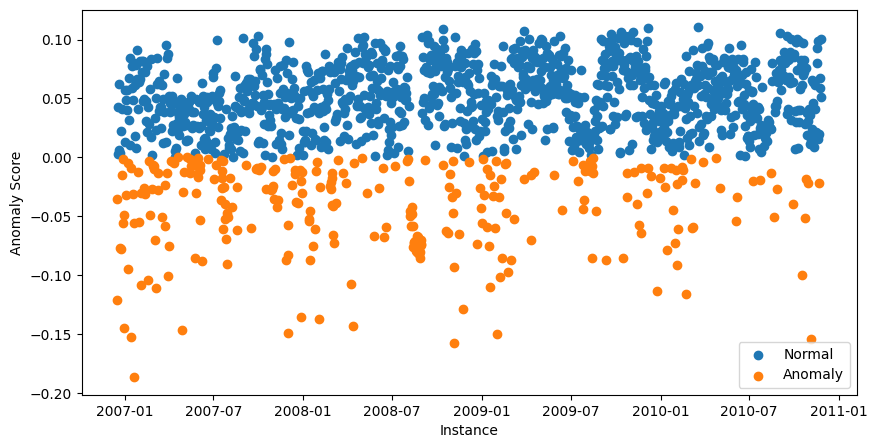

In [9]:
plt.figure(figsize=(10, 5))

normal = data_aggregated[data_aggregated['anomaly'] == 1]
plt.scatter(normal['Date'], normal['anomaly_score'], label='Normal')

anomalies = data_aggregated[data_aggregated['anomaly'] == -1]
plt.scatter(anomalies['Date'], anomalies['anomaly_score'], label='Anomaly')

plt.xlabel("Instance")
plt.ylabel("Anomaly Score")
plt.legend()

## KernelSHAP with Anomaly Score

In [ ]:
# using the anomaly score and TressSHAP (this code won't work)
explainer = shap.TreeExplainer(iso_forest.decision_funtion, features)
shap_values = explainer(features)

In [11]:
# select all anomalies and 100 random normal instances
normal_sample = np.random.choice(normal.index,size=100,replace=False)
sample = np.append(anomalies.index,normal_sample)

len(sample) #387

387

In [12]:
# using the anomaly score and KernelSHAP
explainer = shap.Explainer(iso_forest.decision_function, features)
shap_values = explainer(features.iloc[sample])

PermutationExplainer explainer: 388it [03:10,  1.99it/s]


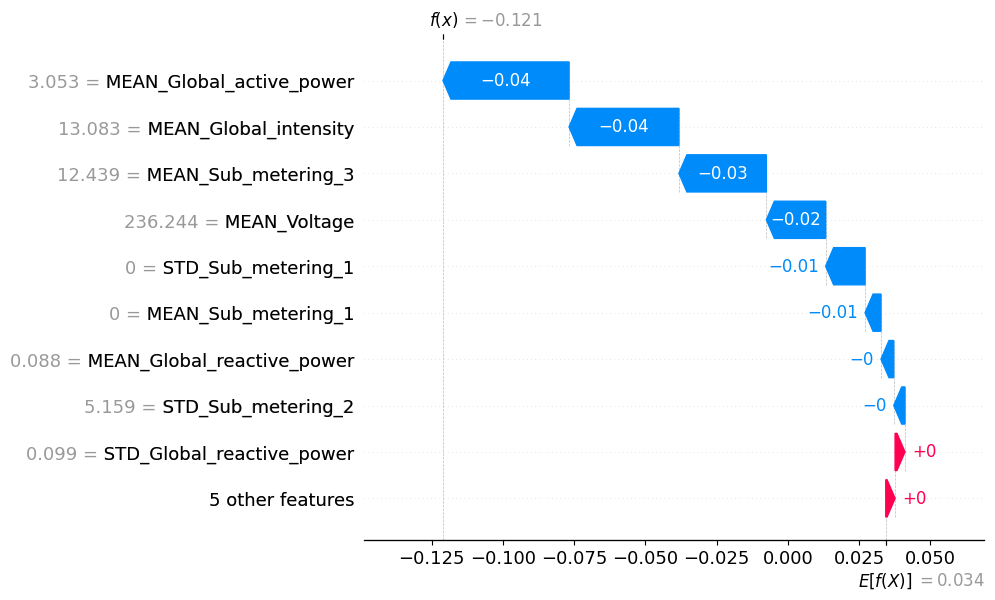

In [13]:
# plot waterfall plot of an anomaly
shap.plots.waterfall(shap_values[0])

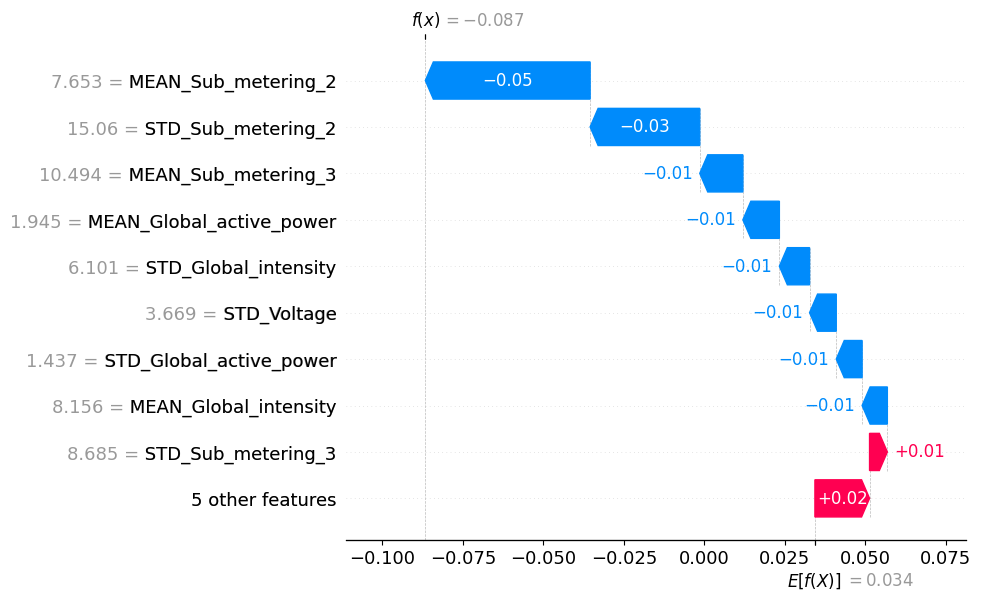

In [15]:
# plot waterfall plot of a normal instance
shap.plots.waterfall(shap_values[100])

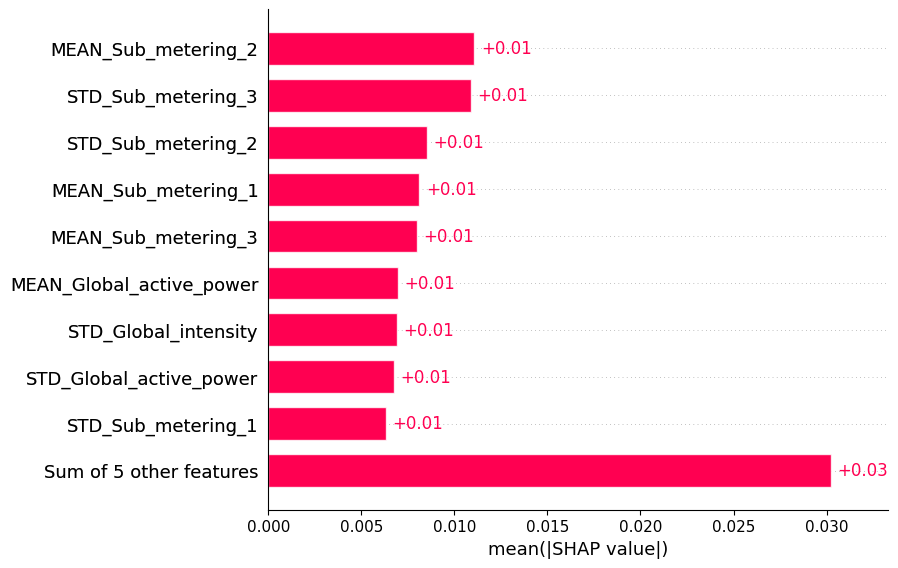

In [14]:
# MeanSHAP Plot
shap.plots.bar(shap_values)

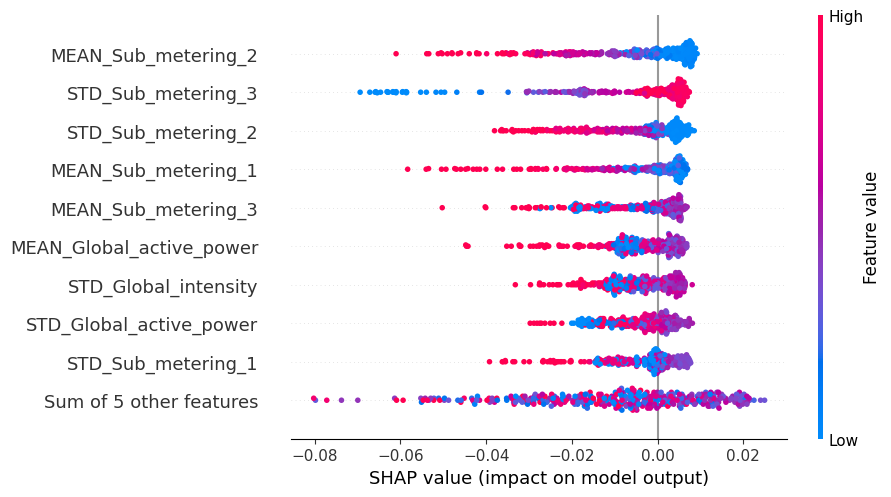

In [16]:
# Beeswarm plot
shap.plots.beeswarm(shap_values)

TreeSHAP with Path Length

In [17]:
# calculate SHAP values
explainer = shap.TreeExplainer(iso_forest)
shap_values = explainer(features)

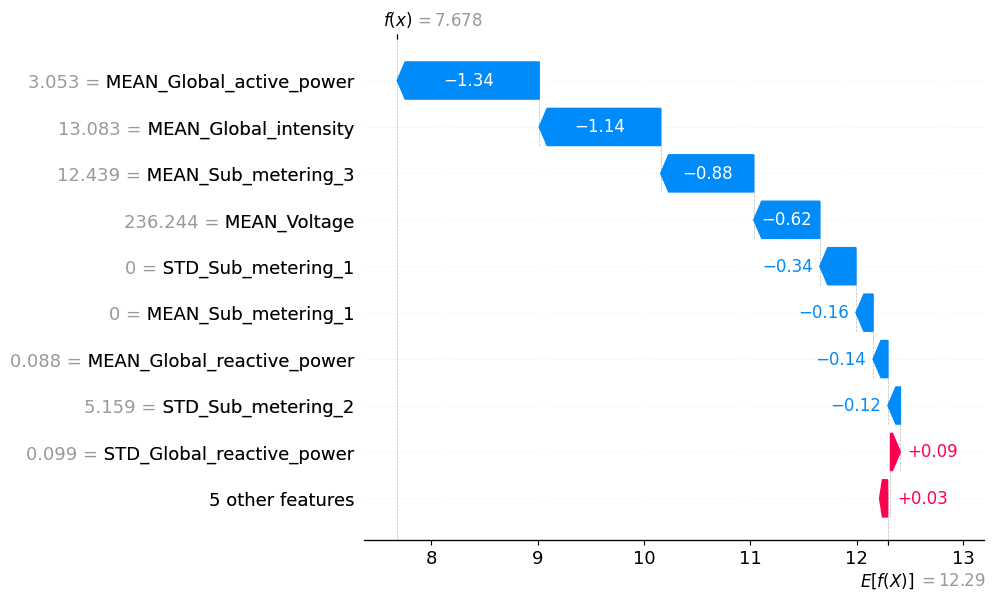

In [18]:
# waterfall plot for an anomaly
shap.plots.waterfall(shap_values[0])

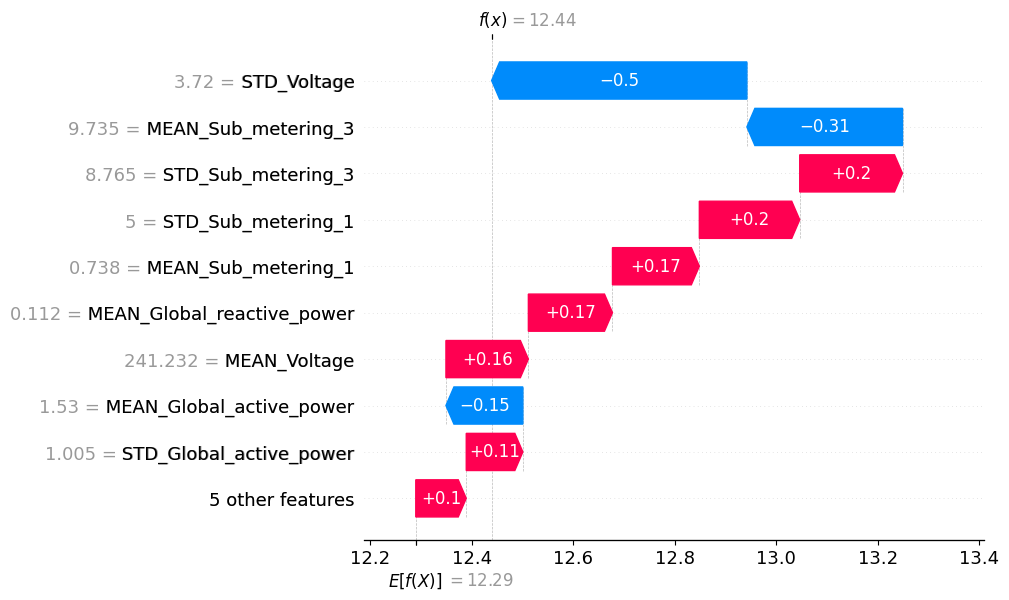

In [19]:
# waterfall plot for an normal instance
shap.plots.waterfall(shap_values[2])

/tmp/ipython-input-2539907716.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([path_length_anomalies, path_length_normal], labels=['Anomaly', 'Normal'])


Text(0, 0.5, 'Average Path Length f(x)')

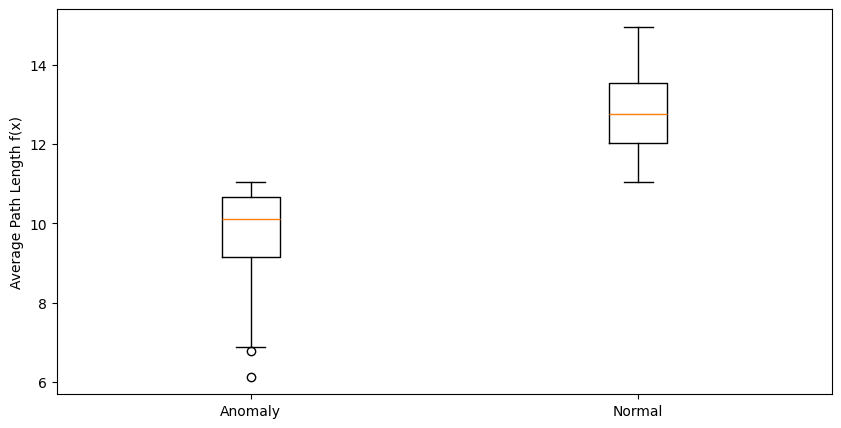

In [20]:
# calculate f(x)
path_length = shap_values.base_values + shap_values.values.sum(axis=1)

# gte f(x) for anomalies and normal instances
anomalies = data_aggregated[data_aggregated['anomaly'] == -1]
path_length_anomalies = path_length[anomalies.index]

normal = data_aggregated[data_aggregated['anomaly'] == 1]
path_length_normal = path_length[normal.index]

# plot boxplots for f(x)
plt.figure(figsize=(10, 5))
plt.boxplot([path_length_anomalies, path_length_normal], labels=['Anomaly', 'Normal'])
plt.ylabel("Average Path Length f(x)")

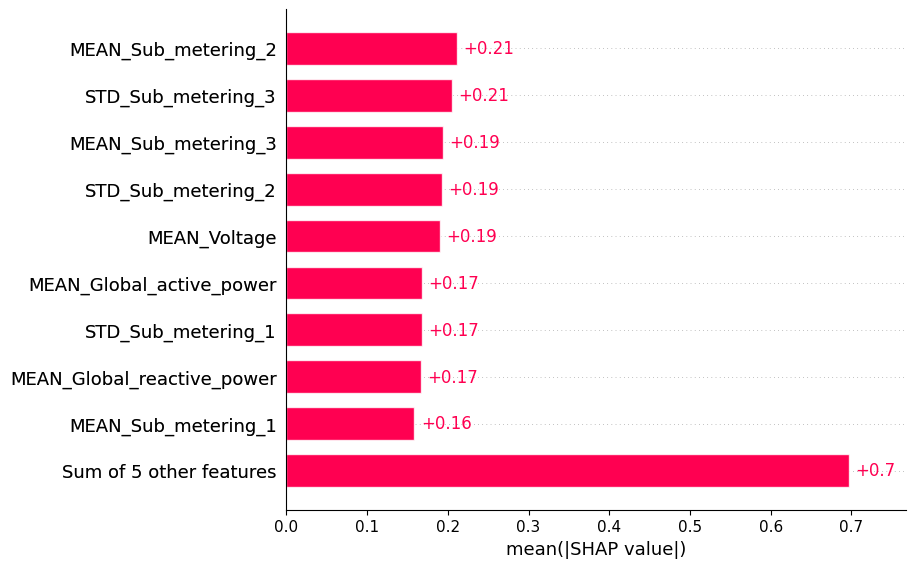

In [21]:
# MeanSHAP
shap.plots.bar(shap_values)

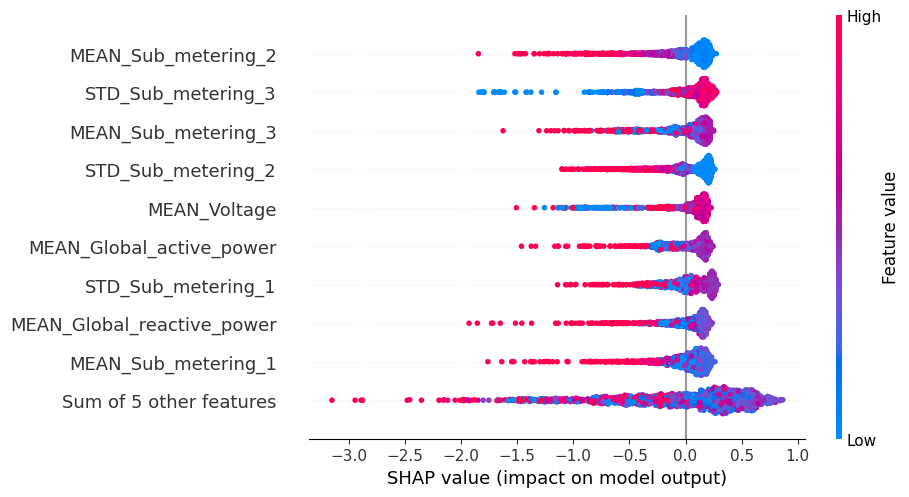

In [22]:
# MeanSHAP
shap.plots.beeswarm(shap_values)

In [23]:
# interaction values
shap_interaction_values = explainer.shap_interaction_values(features)

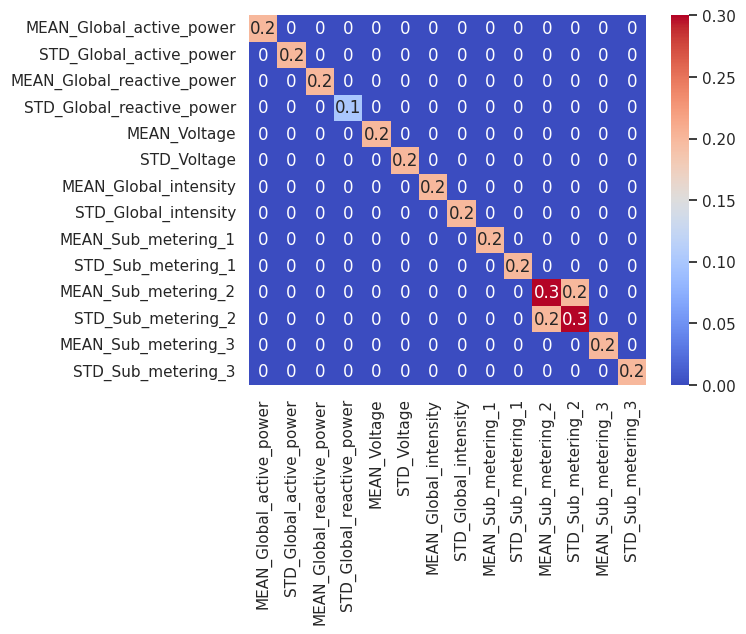

In [25]:
# get absolute mean of matrices
mean_shap = np.abs(shap_interaction_values).mean(0)
mean_shap = np.round(mean_shap, 1)

df = pd.DataFrame(mean_shap, columns=features.columns, index=features.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df), df.values * 2, inplace=True)

# display
sns.set(font_scale=1)
sns.heatmap(df, cmap="coolwarm", annot=True)
plt.yticks(rotation=0)

plt.savefig('if_interaction_values.png', bbox_inches='tight', dpi=300)